# Detection of coronary artery tree using morphological Operator
## S Eiho, Y Qian

### Structuring Elements

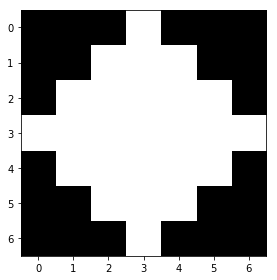

In [207]:
import numpy as np
from skimage import io
from numba import jit
from skimage import img_as_ubyte
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import warnings
import skimage.morphology as m

@jit(nopython = True)
def getDiamondSE(size):
    size = (size * 2) + 1
    elem = np.zeros((size, size), dtype=np.uint8)
    mid = int(size / 2)
    for i in range(size):
        elem[i, mid] = 255
        if i < size-mid:
            for j in range(i):
                elem[i, mid - (j + 1)] = 255
                elem[i, mid + (j +1 )] = 255
        else:
            for j in range(size - i-1):
                elem[i, mid - (j + 1)] = 255
                elem[i, mid + (j + 1)] = 255
    return elem

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    io.imshow(getDiamondSE(3))
    io.show()

### Morphological Operators
#### Dilatation

In [208]:
@jit(nopython = True, nogil=True, parallel=True)
def __evalFunc(func, img, selem, i, j):
    _val = img[i, j]
    _pos = int(selem.shape[0]/2)
    for x in range(selem.shape[0]):
        val_y = x - _pos
        if val_y + i < 0 or  val_y + i >= img.shape[0] : continue
        for y in range(selem.shape[1]):
            val_x = y - _pos
            if val_x + j < 0 or val_x + j >= img.shape[1]: continue
            if selem[x, y] :
                if func == 0 and img[val_y + i, val_x + j] > _val:
                    _val = img[val_y + i, val_x + j]
                if func == 1 and img[val_y + i, val_x + j] < _val:
                    _val = img[val_y + i, val_x + j]
    return _val
@jit(nopython = True, nogil=True, parallel=True)
def __doOperation(func, img, selem):
    _img = np.zeros_like(img)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            _img[i, j] = __evalFunc(func, img, selem, i,j)
    return _img

def dilation(img, selem):
    _img = __doOperation(0, img, selem)
    return _img

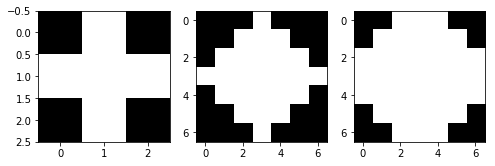

In [209]:
se = getDiamondSE(1)
s2 = getDiamondSE(3)
f, (ax1, ax2 ,ax3) = plt.subplots(1, 3, figsize=(8,8))
ax1.imshow(se, cmap='gray')
ax2.imshow(s2, cmap='gray')
imgn = dilation(s2, se)
ax3.imshow(imgn, cmap='gray')
plt.show()
# print(imgn)

/Users/jperalta/miniconda2/envs/py36/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


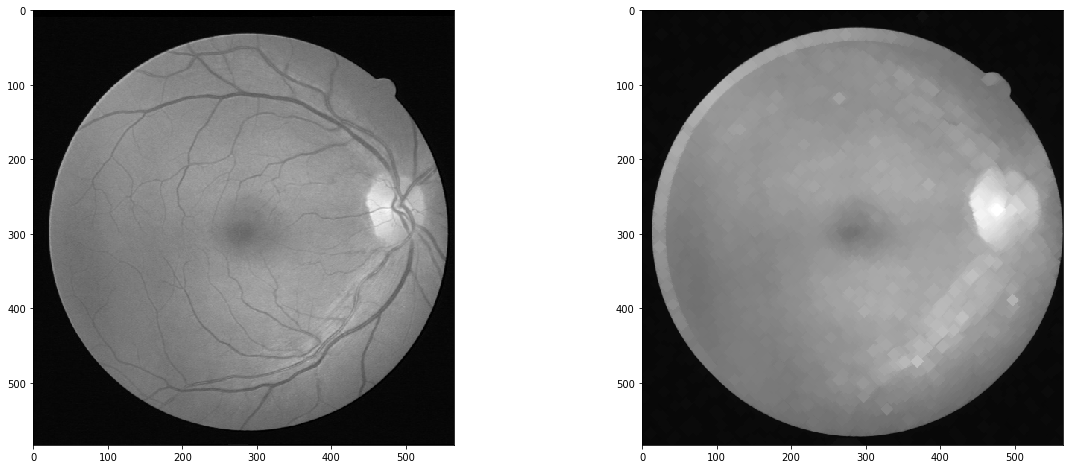

CPU times: user 599 ms, sys: 22.5 ms, total: 621 ms
Wall time: 621 ms


In [210]:
%%time
import warnings
filename = './Set2_imagenes/28_training.tif'
img = img_as_ubyte(rgb2gray(io.imread(filename)))
img2 = dilation(img, getDiamondSE(8))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.imshow(img , cmap='gray')
ax2.imshow(img2, cmap='gray')
plt.show()

#### Erosion

In [211]:
def erosion(img, selem):
    _img = doOperation(1, img, selem)
    return _img

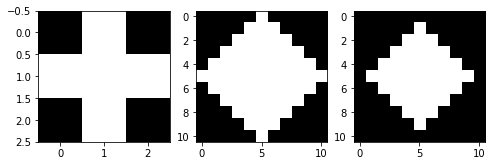

In [212]:
se = getDiamondSE(1)
s2 = getDiamondSE(5)
f, (ax1, ax2 ,ax3) = plt.subplots(1, 3, figsize=(8,8))
ax1.imshow(se, cmap='gray')
ax2.imshow(s2, cmap='gray')
imgn = erosion(s2, se)
ax3.imshow(imgn, cmap='gray')
plt.show()

/Users/jperalta/miniconda2/envs/py36/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


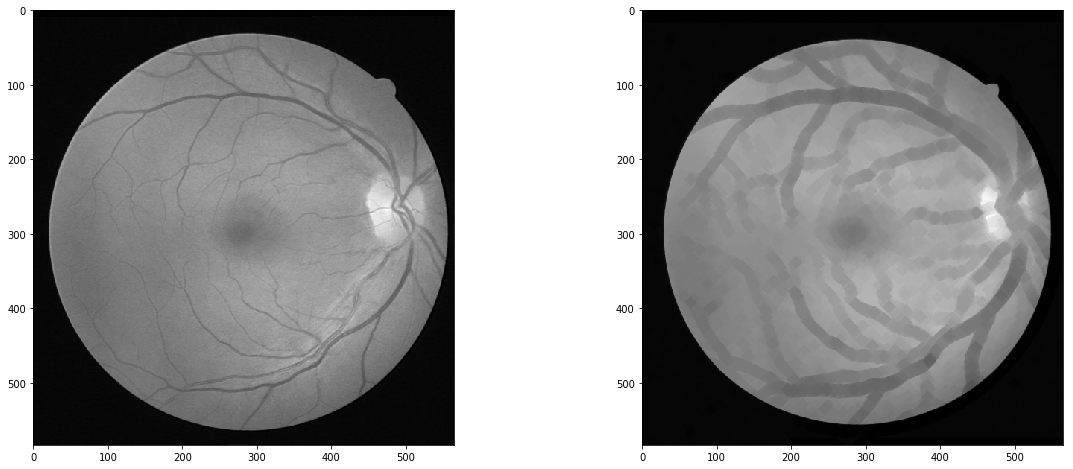

In [225]:
img = img_as_ubyte(rgb2gray(io.imread(filename)))
img2 = erosion(img, getDiamondSE(8))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.imshow(img, cmap='gray')
ax2.imshow(img2, cmap='gray')
plt.show()

#### Opening

In [214]:
def opening(img, selem):
    img2 = erosion(img, selem)
    return dilation(img2, selem)

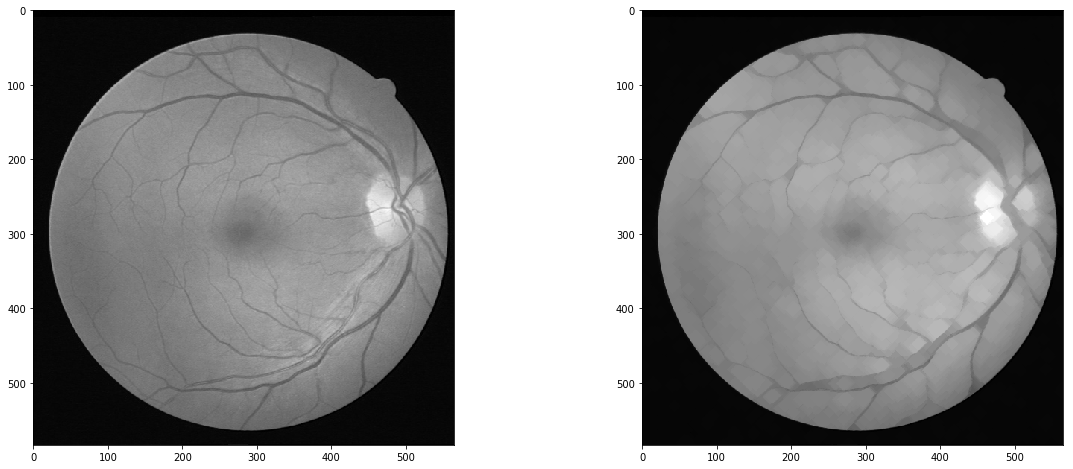

CPU times: user 722 ms, sys: 11.8 ms, total: 734 ms
Wall time: 732 ms


In [226]:
%%time
img2 = opening(img, getDiamondSE(8))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.imshow(img, cmap='gray')
ax2.imshow(img2, cmap='gray')
plt.show()

#### Closing

In [216]:
# @jit(nopython = True)
def closing(img, selem):
    img2 = dilation(img, selem)
    return erosion(img2, selem)

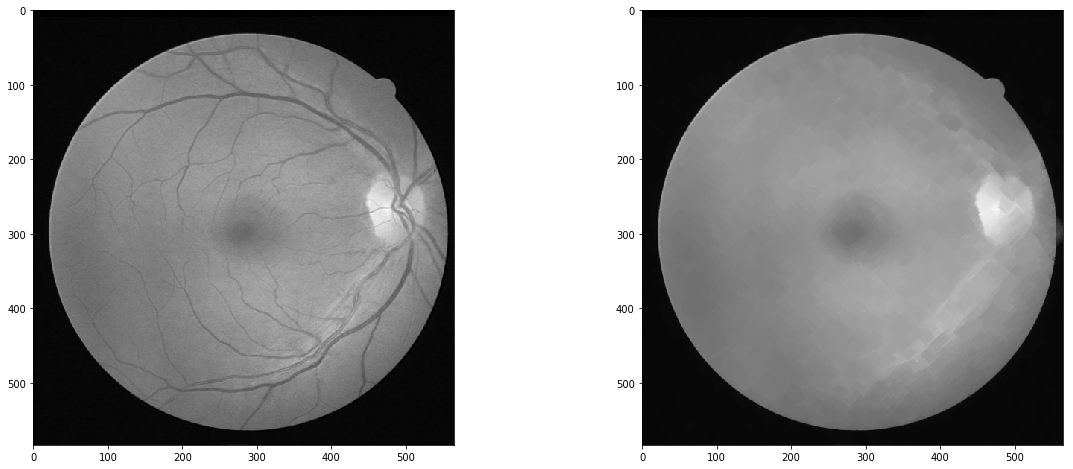

CPU times: user 720 ms, sys: 10.4 ms, total: 731 ms
Wall time: 729 ms


In [227]:
%%time
img2 = closing(img, getDiamondSE(8))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.imshow(img, cmap='gray')
ax2.imshow(img2, cmap='gray')
plt.show()

#### TopHat

In [218]:
# @jit(nopython = True)
def white_topHat(img, selem):
    img2 = opening(img, selem)
    for i in range(img.shape[0]) :
        for j in range(img.shape[1]) :
            v = int(img[i,j]) - int(img2[i,j])
            if v < 0 : v = 0
            img2[i,j] = v
    return img2

def black_topHat(img, selem):
    img2 = closing(img, selem)
    for i in range(img.shape[0]) :
        for j in range(img.shape[1]) :
            v =  int(img2[i,j]) - int(img[i,j])
            if v < 0 : v = 0
            img2[i,j] = v
    return img2

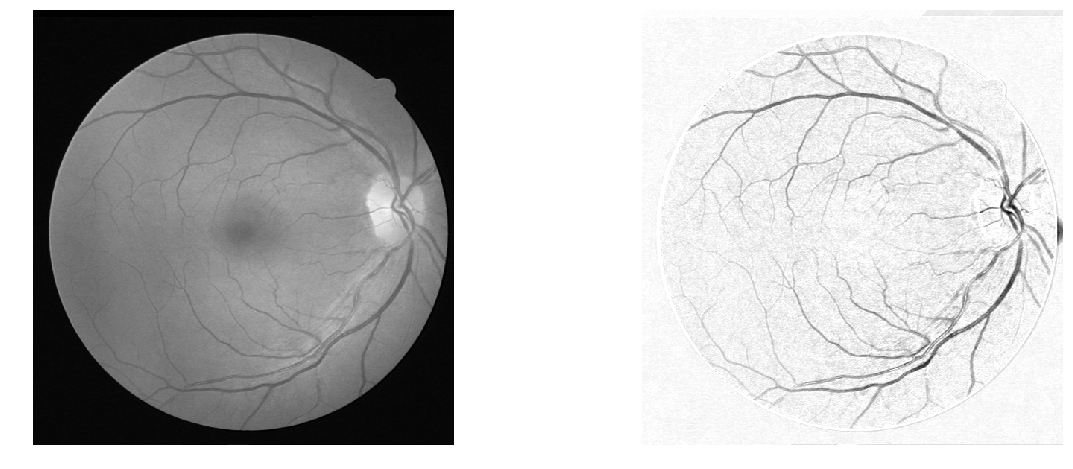

CPU times: user 1 s, sys: 7.52 ms, total: 1.01 s
Wall time: 1.01 s


In [223]:
%%time
img2 = black_topHat(img, getDiamondSE(8))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.imshow(img, cmap='gray')
ax1.axis('off')

ax2.imshow(255 - img2, cmap='gray')
ax2.axis('off')

plt.show()

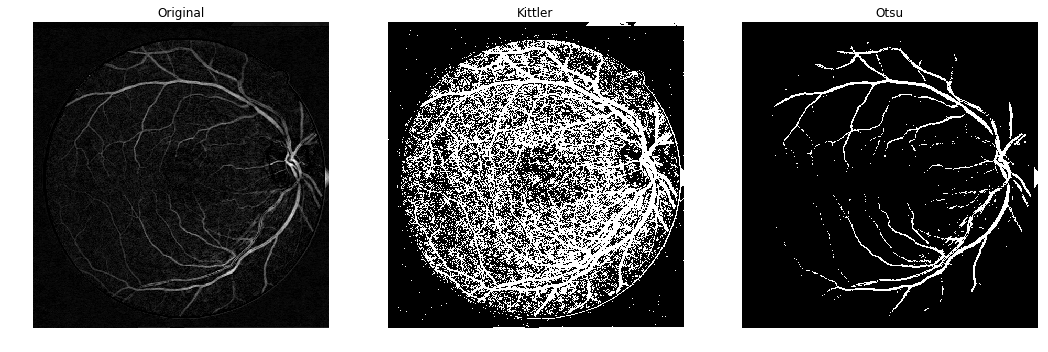

In [224]:
# img2 = 255 - img2
import kittler
from skimage.filters import threshold_otsu, threshold_local, rank

fig, axes = plt.subplots(ncols=3, figsize=(18, 18))
ax = axes.ravel()
plt.gray()

ax[0].imshow(img2, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(img2 > kittler.buscaUmbral(img2, img2.mean()), cmap='gray')
ax[1].axis('off')
ax[1].set_title('Kittler')

ax[2].imshow(img2 > threshold_otsu(img2), cmap='gray')
ax[2].axis('off')
ax[2].set_title('Otsu')

plt.show()